# S&DS 617 Applied Machine Learning and Causal Inference Research Seminar: Assignment 2

**Deadline**

Assignment 2 is due Monday, March 24th at 1:30pm. Late work will not be accepted.


**Submission**

Submit your assignment as a .pdf on Gradescope. On Gradescope, there are 2 assignments, one where you will submit a pdf file and one where you will submit the corresponding .ipynb that generated it. 
Note: The problems in each homework assignment are numbered.When submitting the pdf on Gradescope, please select the correct pages that correspond to each problem. 

To produce the .pdf, do the following to preserve the cell structure of the notebook:
- Go to "File" at the top-left of your Jupyter Notebook
- Under "Download as", select "HTML (.html)"
- After the .html has downloaded, open it and then select "File" and "Print"
- From the print window, select the option to save as a .pdf

## Problem 1

In this exercise, we'll employ different prompt tuning techniques on GSM8k dataset [Link](https://github.com/openai/grade-school-math/tree/master/grade_school_math/data).

The GSM8K dataset is an OpenAI-curated collection of 8,500 grade school math problems designed to challenge and evaluate the mathematical reasoning capabilities of language models. It contains approximately 7,500 training and 1,000 test problems that require 2 to 8 steps to solve, using basic arithmetic operations. The dataset aims to diagnose current model limitations in multi-step reasoning and supports advancements in AI's understanding and processing of natural language math problems. It includes both standard problems and a Socratic format with guiding subquestions, along with calculation annotations to aid in accuracy, making it a valuable resource for AI research in natural language processing.

Below, we have provided helper functions to load the data. 

In [1]:
import requests
import tarfile
import os
import json
import re
import openai
import pandas as pd

# Function to load data from a URL
def load_data_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        data = [json.loads(line) for line in response.iter_lines(decode_unicode=True)]
        df = pd.DataFrame(data)
        return df
    else:
        print(f"Failed to download the file: {response.status_code}")
        return None

# Function to get the true solution from JSON file 
def extract_solution(problem):
    """
    Extracts the final numeric solution from a problem dictionary with 'question' and 'answer' keys.
    The answer is expected to contain a '####' token followed by the final numeric solution.
    
    :param problem: A dictionary with 'question' and 'answer' keys.
    :return: The final numeric solution as a string.
    """
    # Split the answer into lines
    answer_lines = problem['answer'].split('\n')
    # Look for the line with the '####' token
    for line in answer_lines:
        if '####' in line:
            # Extract the numeric solution that follows the '####' token
            solution = line.split('####')[-1].strip()
            return solution
    # If no solution is found, return None
    return None

### Load Data

In [2]:
# URLs for the train and test data
train_url = "https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/train.jsonl"
test_url = "https://raw.githubusercontent.com/openai/grade-school-math/master/grade_school_math/data/test.jsonl"

# Load the training data
df_train = load_data_from_url(train_url)
df_train = df_train.sample(n=1000, random_state=928)

# Load the test data
df_test = load_data_from_url(test_url)
df_test = df_test.sample(n=500, random_state=184)

# Display the lengths of the datasets as a check
len(df_train), len(df_test)

(1000, 500)

In [30]:
sample_row = df_test.iloc[15,] 
print(sample_row)
# print(df_train.head)

question    Bob wants to dig a hole 6 feet long by 4 feet ...
answer      The hole is 6 feet long by 4 feet wide by 3 fe...
Name: 639, dtype: object


In [31]:
# print(sample_row['question']) # sample question
print(sample_row['answer'])

The hole is 6 feet long by 4 feet wide by 3 feet deep or 6 * 4 * 3 = <<6*4*3=72>>72 cubic feet.
Bob shovels a cubic foot of earth every 3 seconds so it will take 72 * 3 = <<72*3=216>>216 seconds to dig the hole.
#### 216


In [32]:
# Extract the solution
extract_solution(sample_row)

'216'

a) Implement zero shot learning, few shot learning, and chain of thought prompting using gpt-4o. Make a figure or table comparing the accuracy of each on the test set and comment on your results and whether they align with your expectations. Sample at most 1000 observations. Again, remember to start with a smaller subset of your dataset to ensure your implementation is correct before scaling up. 

In [8]:
from dotenv import load_dotenv

# Load environment variables from the .env file
load_dotenv()

# Access the OpenAI API key
openai_api_key = os.getenv("OPENAI_API_KEY")

# Use the API key
if openai_api_key:
    print("OpenAI API Key loaded successfully!")
else:
    print("OpenAI API Key not found. Please check your .env file.")

client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))


OpenAI API Key loaded successfully!


In [9]:
def query_gpt(system_prompt, question, model_name="gpt-4o"):
    try:
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {
                    "role": "user", "content": system_prompt
                },
                {
                    "role": "user", "content": question
                }],
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error querying GPT: {e}")
        return ""


def extract_solution_from_gpt(response):
    try:
        answer_lines = response.split('\n')
    except:
        return None
    
    # Regular expression to match "#### -number" or "#### number"
    pattern = r"####\s*(-?\d+)"
    
    for line in answer_lines:
        match = re.search(pattern, line)
        if match:
            return match.group(1)  # Extract the number, including the minus sign if present
    
    return None  # If no valid answer is found


def check_answer(ans, soln):
    if isinstance(ans, str):
        # Remove commas and extra spaces
        ans = ans.replace(",", "").strip()
        # Convert to float and back to string to normalize formatting
        try:
            ans = str(float(ans))
        except ValueError:
            pass  # If it can't be converted, return as-is
    if isinstance(soln, str):
        # Remove commas and extra spaces
        soln = soln.replace(",", "").strip()
        # Convert to float and back to string to normalize formatting
        try:
            soln = str(float(soln))
        except ValueError:
            pass  # If it can't be converted, return as-is
    return ans == soln


def few_shot_prompt(train_data, num_shots):
    # Sample question-solution examples from training set

    sampled_df = train_data.sample(n=num_shots, random_state=42)
    # print(sampled_df)
    prompt = "Here are a few examples: \n"
    for i in range(len(sampled_df)):
        prompt += f"Example {i+1}: \n"
        row = sampled_df.iloc[i,]
        # print(row)
        prompt += f"question: {row['question']} \n"
        prompt += f"answer: {row['answer']} \n"

    return prompt
    

In [142]:
initial_prompt = """You are a math master. I will give the math problems to solve. Please provide your final numerical solution directly in the format: #### solution. \n
                    Please only give numbers without any unit \n
                    For example: #### 1 \n"""

In [56]:
# Zero shot learning

# question = sample_row['question']
# response = query_gpt(initial_prompt, question)
# print(response)
# print(extract_solution_from_gpt(response))
correctness = 0
for i in range(500):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    gpt_response = query_gpt(initial_prompt, row["question"])
    answer = extract_solution_from_gpt(gpt_response)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(answer, solution):
        correctness += 1
        
print(f"Zero-shot accuracy = {correctness/500}")


Zero-shot accuracy = 0.768


In [143]:
# Few shot learning
num_exp = 2

correctness = 0
for i in range(500):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    prompt = initial_prompt + few_shot_prompt(df_train, num_exp)
    # print(prompt)
    gpt_response = query_gpt(prompt, row["question"])
    answer = extract_solution_from_gpt(gpt_response)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(answer, solution):
        correctness += 1
    if i % 50 == 0:
        print(f"{i / 500} done")
        
print(f"Few-shot accuracy = {correctness/500}")


0.0 done
0.1 done
0.2 done
0.3 done
0.4 done
0.5 done
0.6 done
0.7 done
0.8 done
0.9 done
Few-shot accuracy = 0.858


In [81]:
# Chain of thought prompting

cot_prompt = "Let's think step by step"

correctness = 0
for i in range(500):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    # print(prompt)
    gpt_response = query_gpt(initial_prompt, row["question"]+cot_prompt)
    answer = extract_solution_from_gpt(gpt_response)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(answer, solution):
        correctness += 1
        
print(f"CoT accuracy = {correctness/500}")

CoT accuracy = 0.92


     Methods  Accuracy
0  Zero shot     0.768
1   Few shot     0.858
2        CoT     0.920


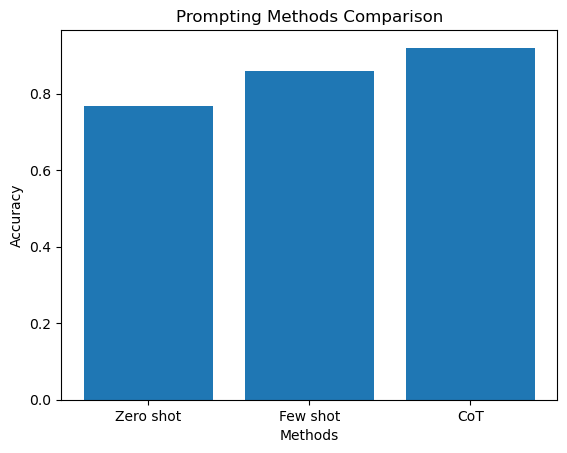

In [5]:
accuracies = [0.768, 0.858, 0.92]
methods = ["Zero shot", "Few shot", "CoT"]
result = pd.DataFrame({
    "Methods": methods,
    "Accuracy": accuracies
})
print(result)

import matplotlib.pyplot as plt

# Create the bar plot
plt.bar(result['Methods'], result['Accuracy'])

# Add labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Prompting Methods Comparison')

# Show the plot
plt.show()

- This follows my expectation as these problems require multi-step reasoning. So I expect to see that CoT prompting gives the highest accuracy.

b)  Explore recent literature for reasoning methods that could enhance the performance of CoT and improve the baseline obtained in a). Then, compare the results with the reasoning models o1-mini and o3-mini, and discuss your findings.

In [14]:
# o1-mini
correctness = 0
for i in range(500):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    # print(row["question"])
    gpt_response = query_gpt(initial_prompt, row["question"], model_name="o1-mini")
    answer = extract_solution_from_gpt(gpt_response)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(answer, solution):
        correctness += 1
    if i % 50 == 0:
        print(f"{i / 500} done")
        
print(f"Zero-shot accuracy for o1-mini = {correctness/500}")


0.0 done
0.1 done
0.2 done
0.3 done
0.4 done
0.5 done
0.6 done
0.7 done
0.8 done
0.9 done
Zero-shot accuracy for o1-mini = 0.962


In [15]:
# o3-mini
correctness = 0
for i in range(500):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    # print(row["question"])
    gpt_response = query_gpt(initial_prompt, row["question"], model_name="o3-mini")
    answer = extract_solution_from_gpt(gpt_response)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(answer, solution):
        correctness += 1
    if i % 50 == 0:
        print(f"{i / 500} done")
        
print(f"Zero-shot accuracy for o3-mini = {correctness/500}")

0.0 done
0.1 done
0.2 done
0.3 done
0.4 done
0.5 done
0.6 done
0.7 done
0.8 done
0.9 done
Zero-shot accuracy for o3-mini = 0.974


#### Implement ReAct method with Calculator call:

In [3]:
import sympy as sp

In [11]:
def extract_and_evaluate(expression):
    """Extracts and evaluates an algebraic expression inside Calculate[]."""
    match = re.search(r"Calculate\[(.*?)\]", expression)
    if match:
        math_expr = match.group(1)  # Extract the expression
        try:
            result = sp.sympify(math_expr)  # Safe symbolic evaluation
            return str(result)  # Convert to string
        except Exception as e:
            # return f"Error: {e}"  # Handle invalid expressions
            return "No calculation performed. Please only add numerical values and try again."
    return "No calculation performed."  # No calculation needed

def llm(prompt, stop=["\n"]):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0,
        max_tokens=1000,
        top_p=1,
        frequency_penalty=0.0,
        presence_penalty=0.0,
        stop=stop
    )
    return response.choices[0].message.content

# Function to simulate an environment step (LLM → Action → Calculation → Feedback)
def step(action):
    """Processes the action generated by LLM and returns the observation."""
    obs_result = extract_and_evaluate(action)
    if obs_result:
        return f"The result is {obs_result}.", obs_result
    return "No calculation performed.", None

# Function to run the ReAct reasoning loop
def react_reasoning(question, initial_prompt, max_steps=20, to_print=True):
    prompt = initial_prompt + f"Question: {question}\n\n" + "Let's think step by step. \n\n"
    n_calls, n_badcalls = 0, 0
    
    for i in range(1, max_steps + 1):
        n_calls += 1
        thought_action = llm(prompt + f"Thought:", stop=[f"\nObservation:"])
        
        try:
            thought, action = thought_action.strip().split(f"\nAction: ")
        except:
            print(f'Parsing issue:', thought_action)
            n_badcalls += 1
            thought = thought_action.strip().split('\n')[0]
            action = llm(prompt + f"Thought: {thought}\nAction:", stop=["\n"]).strip()
        
        # Check if the response contains a final answer
        if "Final Answer:" in action:
            # print(f"Thought {i}: {thought}\nAction {i}: {action}\n")
            final_answer = action.split("Final Answer:")[-1].strip()
            
            final_answer = extract_solution_from_gpt(final_answer)
            
            # print(f"\nFinal Answer: {final_answer}")
            return final_answer, {"n_calls": n_calls, "n_badcalls": n_badcalls, "traj": prompt}


        obs, result = step(action)
        
        # Build step log
        step_str = f"Thought: {thought}\nAction: {action}\nObservation: {obs}\n"
        prompt += step_str

        if to_print:
            print(step_str)

    # print(n_calls)
    return None, {"n_calls": n_calls, "n_badcalls": n_badcalls, "traj": prompt}


In [6]:
def construct_react_prompt(train_data, num_shots=2):
    sampled_df = train_data.sample(n=num_shots, random_state=42)
    prompt = "Here are a few examples: \n"
    reformat_prompt = """
                        Please reformat the answer in the format similar to this example: \n
                        Question: Bob wants to dig a hole 6 feet long by 4 feet wide by 3 feet deep. If it takes him 3 seconds to shovel a cubic foot of earth, how long will it take him to dig the hole? \n
                        Thought: To find out how long it will take Bob to dig the hole, I first need to calculate the volume of the hole in cubic feet. The volume of a rectangular prism is found by multiplying its length, width, and depth.\n
                        Action: Calculate[6 * 4 * 3]\n
                        Observation: The result of Calculate[6 * 4 * 3] is 72.\n
                        Thought: The volume of the hole is 72 cubic feet. Now, I need to calculate the total time it will take Bob to dig the hole by multiplying the volume by the time it takes to shovel each cubic foot.\n
                        Action: Calculate[72 * 3]\n
                        Observation: The result of Calculate[72 * 3] is 216.\n
                        Thought: The total time it will take Bob to dig the hole is 216 seconds.\n
                        Action: Final Answer: #### 216 \n\n
                        Please transfer percentage into decimal form before put into Calculate[expression]. \n
                    """
    
    for i in range(len(sampled_df)):
        prompt += f"Example {i+1}: \n"
        row = sampled_df.iloc[i,]
        # print(row)
        reformatted_answer = query_gpt(reformat_prompt, row['question']+row['answer'], model_name="o3-mini")
        # print(reformatted_answer)
        
        prompt += reformatted_answer
    return prompt

In [10]:
reasoning_prompt = """You are a math master. Please solve the following math problem step by step using reasoning and actions. \n
Please give one pair of thought and action each time and stop to wait for observation. \n
You are equipped with a method: Calculate[expression] to perform addition, subtraction, multiplication, and division. Please only add numerical values without any units or variables in it.\n
""" + construct_react_prompt(df_train)
print(reasoning_prompt)

You are a math master. Please solve the following math problem step by step using reasoning and actions. 

Please give one pair of thought and action each time and stop to wait for observation. 

You are equipped with a method: Calculate[expression] to perform addition, subtraction, multiplication, and division. Please only add numerical values without any units or variables in it.

Here are a few examples: 
Example 1: 
Question: At a pool party, there are 4 pizzas cut into 12 slices each. If the guests eat 39 slices, how many slices are left?

Thought: To determine how many slices are left, first calculate the total number of slices by multiplying the number of pizzas by the slices per pizza.

Action: Calculate[4 * 12]

Observation: The result of Calculate[4 * 12] is 48.

Thought: Now, subtract the number of slices eaten (39) from the total slices (48) to get the remaining slices.

Action: Calculate[48 - 39]

Observation: The result of Calculate[48 - 39] is 9.

Thought: Therefore, aft

In [12]:
correctness = 0
wrong_answer = []
for i in range(200):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    # print(row["question"])
    final_answer, info = react_reasoning(row['question'], reasoning_prompt, to_print=False)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(final_answer, solution):
        correctness += 1
    else:
        # print(f"Question {i}: {row['question']}")
        wrong_answer.append(i)
        # print(f"Answer: {final_answer}, Solution: {solution}")
    if i % 50 == 0:
        print(f"{i / 200} done")
        
print(f"Accuracy for ReAct agent = {correctness/200}")
print(wrong_answer)

0.0 done
Parsing issue: To determine how long it takes Grandma to complete her entire 3-mile walk, we need to first find her walking speed on the beach and then use that to find her speed on the sidewalk. We know she spends 40 minutes walking 2 miles on the beach.

Action: Calculate her speed on the beach by dividing the distance by the time spent.

Action: Calculate[2 / (40 / 60)] 
Parsing issue: To find the total number of pets in the neighborhood, we need to determine the number of each type of pet: dogs, cats, and rabbits. We know the number of dogs and the relationship between the number of cats and dogs.

Action: Calculate the number of cats by using the given ratio of cats to dogs, which is 2 cats for every dog. Since there are 60 dogs:

Action: Calculate[2 * 60]
Parsing issue: To determine the profit Tim makes from selling 10 jars, we first need to calculate the total cost of ingredients for one jar.

Action: Calculate the cost of passion fruit for one jar by multiplying the po

     Methods  Accuracy
0  Zero shot     0.768
1   Few shot     0.858
2        CoT     0.920
3    o1-mini     0.962
4    o3-mini     0.974
5      ReAct     0.955


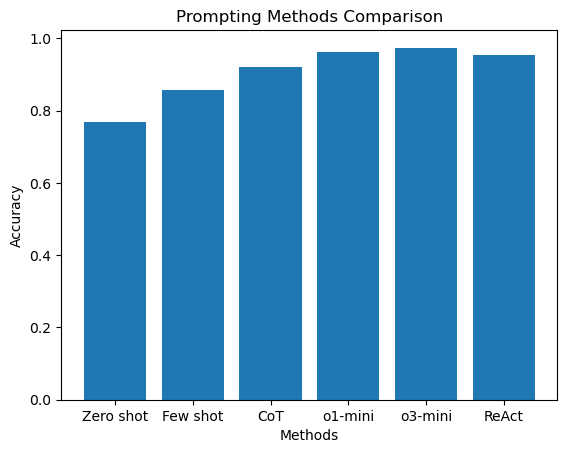

In [13]:
accuracies = [0.768, 0.858, 0.92, 0.962, 0.974, 0.955]
methods = ["Zero shot", "Few shot", "CoT", "o1-mini", "o3-mini", "ReAct"]
result = pd.DataFrame({
    "Methods": methods,
    "Accuracy": accuracies
})
print(result)

import matplotlib.pyplot as plt

# Create the bar plot
plt.bar(result['Methods'], result['Accuracy'])

# Add labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Prompting Methods Comparison')

# Show the plot
plt.show()

- I found that ReAct method surpasses the simple CoT prompting, indicating the effectiveness of this method. However, o1-mini and o3-mini still reached higher accuracy than ReAct.
* This may due to that some questions require solving equations. However, the Calculate[] method we provide can only perform arithmetic operations. Asking the LLM to use this method may break the most natural reasoning chain of solving an equations and cause the LLM to fail.
- Additionally, requiring LLM to follow this thought-action template step by step may limit its free reasoning potential (bitter lesson). So it is expected that ReAct is no better than models that are finetuned to elicit reasoning explicitly.
* Overall, ReAct gives us an easy way to improve the performance for non-reasoning model and allow us to better control LLM's reasoning.

c) Perform an ablation study similar to that of Section 3.3 of Wei et al. 2023: [Link](https://proceedings.neurips.cc/paper_files/paper/2022/file/9d5609613524ecf4f15af0f7b31abca4-Paper-Conference.pdf). Comment on your results.


#### Action only:

- We test whether the improvement in accuracy is merely attributed to the calculator or is the combined effect of calculator and reasoning. In this sense, we let the model to give calculation action without reasoning and compare the results.

In [14]:
def construct_action_prompt(train_data, num_shots=2):
    sampled_df = train_data.sample(n=num_shots, random_state=42)
    prompt = "Here are a few examples: \n"
    reformat_prompt = """
                        Please reformat the answer in the format similar to this example: \n
                        Question: Bob wants to dig a hole 6 feet long by 4 feet wide by 3 feet deep. If it takes him 3 seconds to shovel a cubic foot of earth, how long will it take him to dig the hole? \n
                        Action: Calculate[6 * 4 * 3]\n
                        Observation: The result of Calculate[6 * 4 * 3] is 72.\n
                        Action: Calculate[72 * 3]\n
                        Observation: The result of Calculate[72 * 3] is 216.\n
                        Action: Final Answer: #### 216 \n\n
                        Please transfer percentage into decimal form before put into Calculate[expression]. \n
                    """
    
    for i in range(len(sampled_df)):
        prompt += f"\nExample {i+1}: \n"
        row = sampled_df.iloc[i,]
        # print(row)
        reformatted_answer = query_gpt(reformat_prompt, row['question']+row['answer'], model_name="o3-mini")
        # print(reformatted_answer)
        
        prompt += reformatted_answer
    return prompt

In [15]:
action_prompt = """You are a math master. Please solve the following math problem step by step using reasoning and actions. \n
Please give one action directly each time and stop to wait for observation. \n
You are equipped with a method: Calculate[expression] to perform addition, subtraction, multiplication, and division. Please only add numerical values without any units or variables in it.\n
""" + construct_action_prompt(df_train)
print(action_prompt)

You are a math master. Please solve the following math problem step by step using reasoning and actions. 

Please give one action directly each time and stop to wait for observation. 

You are equipped with a method: Calculate[expression] to perform addition, subtraction, multiplication, and division. Please only add numerical values without any units or variables in it.

Here are a few examples: 

Example 1: 
Question: At a pool party, there are 4 pizzas cut into 12 slices each. If the guests eat 39 slices, how many slices are left? 

Action: Calculate[4 * 12]  
Observation: The result of Calculate[4 * 12] is 48. 

Action: Calculate[48 - 39]  
Observation: The result of Calculate[48 - 39] is 9. 

Action: Final Answer: #### 9
Example 2: 
Question: Xander read 20% of his 500-page book in one hour. The next night he read another 20% of the book. On the third night, he read 30% of his book. How many pages does he have left to read?

Action: Calculate[0.20 * 500]  
Observation: The result 

In [16]:
def action_reasoning(question, initial_prompt, max_steps=20, to_print=True):
    prompt = initial_prompt + f"Question: {question}\n\n"
    n_calls, n_badcalls = 0, 0
    
    for i in range(1, max_steps + 1):
        n_calls += 1
        action = llm(prompt + f"\nAction:", stop=[f"\nObservation:"])
        # print(action)
        
        # Check if the response contains a final answer
        if "Final Answer:" in action:
            # print(action)
            # print(f"Thought {i}: {thought}\nAction {i}: {action}\n")
            final_answer = action.split("Final Answer:")[-1].strip()
            
            final_answer = extract_solution_from_gpt(final_answer)
            
            # print(f"\nFinal Answer: {final_answer}")
            return final_answer, {"n_calls": n_calls, "n_badcalls": n_badcalls, "traj": prompt}


        obs, result = step(action)
        
        # Build step log
        step_str = f"Action: {action}\nObservation: {obs}\n"
        prompt += step_str

        if to_print:
            print(step_str)

    # print(n_calls)
    return None, {"n_calls": n_calls, "n_badcalls": n_badcalls, "traj": prompt}

In [18]:
correctness = 0
wrong_answer = []
for i in range(200):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    # print(row["question"])
    final_answer, info = action_reasoning(row['question'], action_prompt, to_print=False)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(final_answer, solution):
        correctness += 1
    else:
        # print(f"Question {i}: {row['question']}")
        wrong_answer.append(i)
        # print(f"Answer: {final_answer}, Solution: {solution}")
    if i % 50 == 0:
        print(f"{i / 200} done")
        
print(f"Accuracy for Action-only agent = {correctness/200}")
print(wrong_answer)

0.0 done
0.25 done
0.5 done
0.75 done
Accuracy for Action-only agent = 0.85
[2, 7, 13, 21, 30, 36, 42, 43, 48, 50, 54, 57, 73, 83, 84, 90, 95, 96, 97, 108, 115, 127, 131, 139, 144, 158, 179, 195, 196, 197]


     Methods  Accuracy
0  Zero shot     0.768
1   Few shot     0.858
2        CoT     0.920
3    o1-mini     0.962
4    o3-mini     0.974
5      ReAct     0.955
6   Act-only     0.850


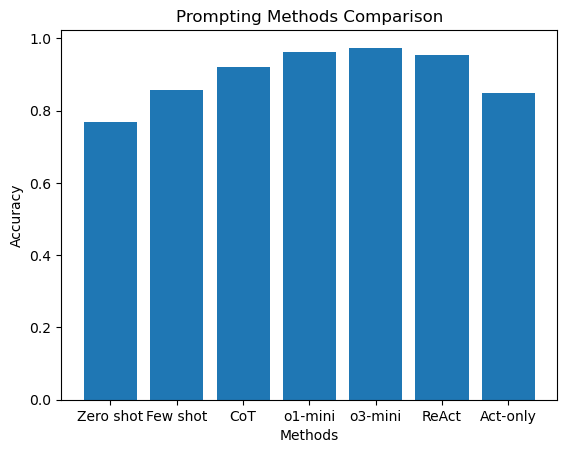

In [19]:
accuracies = [0.768, 0.858, 0.92, 0.962, 0.974, 0.955, 0.85]
methods = ["Zero shot", "Few shot", "CoT", "o1-mini", "o3-mini", "ReAct", "Act-only"]
result = pd.DataFrame({
    "Methods": methods,
    "Accuracy": accuracies
})
print(result)

import matplotlib.pyplot as plt

# Create the bar plot
plt.bar(result['Methods'], result['Accuracy'])

# Add labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Prompting Methods Comparison')

# Show the plot
plt.show()

- We can see that the accuracy is slightly higher than few-shot prompting but significantly lower than CoT and ReAct. This shows that the success of ReAct is attributed to combining reasoning and calculating action.

#### Variable compute only

In [21]:
variable_prompt = """You are a math master. Please solve the following math problem. \n
Please estimate the number of arithmetic calculation need to be done by dots before giving the final answer \n
For examples: \n
Question: Xander read 20% of his 500-page book in one hour. The next night he read another 20% of the book. On the third night, he read 30% of his book. How many pages does he have left to read? \n
Answer: ...... #### 150 \n 
Question: At a pool party, there are 4 pizzas cut into 12 slices each. If the guests eat 39 slices, how many slices are left? \n
Answer: .. #### 9 \n
Now, solve the question below: \n
"""

In [22]:
correctness = 0
for i in range(200):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    # print(row["question"])
    gpt_response = query_gpt(variable_prompt, row["question"])
    answer = extract_solution_from_gpt(gpt_response)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(answer, solution):
        correctness += 1
    if i % 50 == 0:
        print(f"{i / 200} done")
        
print(f"Variable compute accuracy for gpt-4o = {correctness/200}")

0.0 done
0.25 done
0.5 done
0.75 done
Variable compute accuracy for gpt-4o = 0.81


#### Reasoning after action

In [23]:
def construct_postreason_prompt(train_data, num_shots=2):
    sampled_df = train_data.sample(n=num_shots, random_state=42)
    prompt = "Here are a few examples: \n"
    reformat_prompt = """
                        Please reformat the answer in the format similar to this example: \n
                        Question: Bob wants to dig a hole 6 feet long by 4 feet wide by 3 feet deep. If it takes him 3 seconds to shovel a cubic foot of earth, how long will it take him to dig the hole? \n
                        Action: Calculate[6 * 4 * 3]\n
                        Observation: The result of Calculate[6 * 4 * 3] is 72.\n
                        Action: Calculate[72 * 3]\n
                        Observation: The result of Calculate[72 * 3] is 216.\n
                        Action: Final Answer: #### 216 \n\n
                        Thought: To find out how long it will take Bob to dig the hole, I first need to calculate the volume of the hole in cubic feet. The volume of a rectangular prism is found by multiplying its length, width, and depth.\n
                        The volume of the hole is 72 cubic feet. Now, I need to calculate the total time it will take Bob to dig the hole by multiplying the volume by the time it takes to shovel each cubic foot.\n
                        The total time it will take Bob to dig the hole is 216 seconds.\n
                        Please transfer percentage into decimal form before put into Calculate[expression]. \n
                    """
    
    for i in range(len(sampled_df)):
        prompt += f"Example {i+1}: \n"
        row = sampled_df.iloc[i,]
        # print(row)
        reformatted_answer = query_gpt(reformat_prompt, row['question']+row['answer'], model_name="o3-mini")
        # print(reformatted_answer)
        
        prompt += reformatted_answer
    return prompt

In [24]:
postreason_prompt = """You are a math master. Please solve the following math problem step by step using reasoning and actions. \n
Please give one action directly each time and stop to wait for observation. \n
You are equipped with a method: Calculate[expression] to perform addition, subtraction, multiplication, and division. Please only add numerical values without any units or variables in it.\n
Please explain your thought after giving the final answer""" + construct_postreason_prompt(df_train)
print(postreason_prompt)

You are a math master. Please solve the following math problem step by step using reasoning and actions. 

Please give one action directly each time and stop to wait for observation. 

You are equipped with a method: Calculate[expression] to perform addition, subtraction, multiplication, and division. Please only add numerical values without any units or variables in it.

Please explain your thought after giving the final answerHere are a few examples: 
Example 1: 
Question: At a pool party, there are 4 pizzas cut into 12 slices each. If the guests eat 39 slices, how many slices are left?

Action: Calculate[4 * 12]  
Observation: The result of Calculate[4 * 12] is 48.

Action: Calculate[48 - 39]  
Observation: The result of Calculate[48 - 39] is 9.

Action: Final Answer: #### 9

Thought: To determine how many slices are left, I first calculate the total number of slices by multiplying the number of pizzas by the number of slices per pizza. This gives me 48 slices. Then, I subtract the 

In [25]:
correctness = 0
wrong_answer = []
for i in range(200):
    row = df_test.iloc[i,]
    solution = extract_solution(row)
    # print(row["question"])
    final_answer, info = action_reasoning(row['question'], postreason_prompt, to_print=False)
    # print(f"Answer: {answer}, Solution: {solution}")
    if check_answer(final_answer, solution):
        correctness += 1
    else:
        # print(f"Question {i}: {row['question']}")
        wrong_answer.append(i)
        # print(f"Answer: {final_answer}, Solution: {solution}")
    if i % 50 == 0:
        print(f"{i / 200} done")
        
print(f"Accuracy for Post-reasoning agent = {correctness/200}")
print(wrong_answer)

0.0 done
0.25 done
0.5 done
0.75 done
Accuracy for Post-reasoning agent = 0.865
[2, 7, 13, 30, 36, 42, 48, 50, 54, 57, 73, 84, 90, 95, 97, 113, 115, 127, 131, 139, 144, 158, 173, 179, 181, 196, 197]


     Methods  Accuracy
0  Zero shot     0.768
1   Few shot     0.858
2        CoT     0.920
3    o1-mini     0.962
4    o3-mini     0.974
5      ReAct     0.955
6   Act-only     0.850
7   Var-comp     0.810
8    PostCoT     0.865


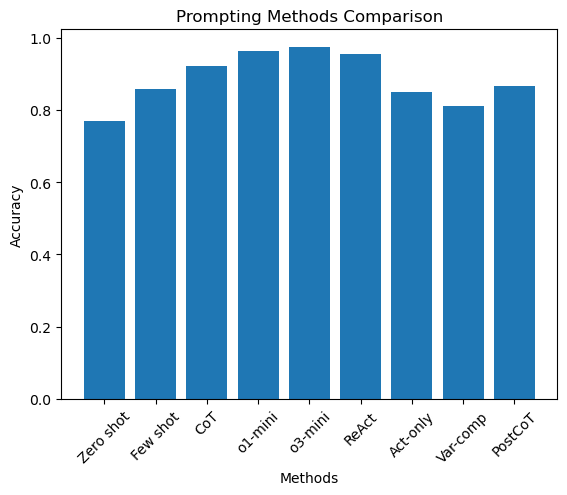

In [32]:
accuracies = [0.768, 0.858, 0.92, 0.962, 0.974, 0.955, 0.85, 0.81, 0.865]
methods = ["Zero shot", "Few shot", "CoT", "o1-mini", "o3-mini", "ReAct", "Act-only", "Var-comp", "PostCoT"]
result = pd.DataFrame({
    "Methods": methods,
    "Accuracy": accuracies
})
print(result)

import matplotlib.pyplot as plt

# Create the bar plot
plt.bar(result['Methods'], result['Accuracy'])

# Add labels and title
plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Prompting Methods Comparison')

# Show the plot
plt.xticks(rotation=45)
plt.show()

- We can see that all of these ablation studies show lower accuracy than the ReAct methods, illustrating the effectiveness of ReAct.
* However, o3-mini still got the highest accuracy. This indicates that structural prompt engineering cannot surpass finetuned reasoning model, further proving the bitter lesson.